<a href="https://colab.research.google.com/github/tombresee/DATACAMP_UML/blob/master/ENTER/notebooks/L2_HyperparameterTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/ML-Challenge/week5-preprocessing-and-tunning/blob/master/L2.Hyperparameter%20Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" /></a>

Building powerful machine learning models depends heavily on the set of hyperparameters used. But with increasingly complex models with lots of options, how do we efficiently find the best settings for our particular problem? In this lesson we will get practical experience in using some common methodologies for automated hyperparameter tuning in Python using Scikit Learn. These include Grid Search & Random Search. We will use a dataset predicting credit card defaults as we build skills to dramatically increase the efficiency and effectiveness of our machine learning model building.

# Setup

In [94]:

# Download lesson datasets
# Required if you're using Google Colab

!wget "https://github.com/ML-Challenge/week5-preprocessing-and-tunning/raw/master/datasets.zip"
!unzip -o datasets.zip


--2020-09-27 04:45:55--  https://github.com/ML-Challenge/week5-preprocessing-and-tunning/raw/master/datasets.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ML-Challenge/week5-preprocessing-and-tunning/master/datasets.zip [following]
--2020-09-27 04:45:56--  https://raw.githubusercontent.com/ML-Challenge/week5-preprocessing-and-tunning/master/datasets.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1846993 (1.8M) [application/zip]
Saving to: ‘datasets.zip.1’

datasets.zip.1      100%[===================>]   1.76M  8.76MB/s    in 0.2s    

2020-09-27 04:45:57 (8.76 MB/s) - ‘datasets.zip.1’ sav

In [95]:
# Import utils
import utils

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
from sklearn.model_selection import train_test_split

# Hyperparameters and Parameters

In this introductory section, we will learn the difference between hyperparameters and parameters. We will practice extracting and analyzing parameters, setting hyperparameter values for several popular machine learning algorithms. Along the way we will learn some best practice tips & tricks for choosing which hyperparameters to tune and what values to set & build learning curves to analyze our hyperparameter choices.

## Introduction & 'Parameters'

Today algorithms are getting more and more complex, and so the number of hyperparameters to choose from increases. It becomes increasingly important to learn how to efficiently find optimal  combinations, as this search will likely take up a large portion of our time. Often it is quite easy to simply run Scikit Learn functions on the default settings or
perhaps code from a tutorial or book without really digging under the hood. However, what lies underneath is of vital importance to good model building.

This lesson will use a dataset about credit card defaults. It contains a number of variables related to the demographics and financial history of a group of people. The target column shows whether or not they defaulted on their next loan payment. It has already been pre-processed and split ready to model. Note that at times we will take smaller samples to ensure we can run the code. 

**Parameters Overview**

To understand hyperparameters, let's first start with parameters. What are parameters?

Parameters are components of the final model that are learned through the modeling process. Crucially, we do not set these. We cannot set these. The algorithm discovers them through undertaking its steps.

To make this concrete, consider a simple logistic regression model. We create the estimator and fit to the data with default settings. 

```
log_reg_clf = LogisticRegression()
log_reg_clf.fit(X_train, y_train)
```

Since the logistic regression model is a linear model, we will get beta coefficients on our variables. These are found in the `coef_` property of our logistic regression object. 

```
print(log_reg_clf.coef_)
```

However, if we print these out we can see it is a bit messy. Let us clean this up by creating a list of original variable names, zipping this up with the coefficients and formatting into a neat DataFrame for easy viewing. 

```
# Get the original variable names
original_variables = list(X_train.columns)

# Zip together the names and coefficients
zipped_together = list(zip(original_variables, log_reg_clf_coef_[0]))
coefs = [list(x) for x in zipped_together]

# Put into a DataFrame with column labels
coefs = pd.DataFrames(coefs, columns=["Variable", "Coefficient"]
```

We can now sort the DataFrame and print the top 3 results for brevity. 

```
coefs.sort_values(by=['Coefficient'], axis=0, inplace=True, asceding=False)
print(coefs.head(3))
```

| Variable | Coefficient |
| -------- | ----------: |
| PAY_0    | 0.000751    |
| PAY_5    | 0.000438    |
| PAY_4    | 0.000435    |

Looking at the code above it is clearly that we didn't set the `PAY_0` to have a coefficient of 0.000751.

The coefficients are parameters because we did not set them ourselves and were learned during the modeling process. In our data, the `PAY` variables relate to how many months people have previously delayed their payments. We can see that having a high number of months of delayed payments, makes someone more likely to default next month. 

**Where to find Parameters**

To know what parameters an algorithm will produce, we need to know a bit about the algorithm itself and how it works and consult the Scikit Learn documentation to see where the parameter is stored in the returned object.

The parameters are found in the documentation for that particular algorithm under the 'Attributes' section, not the parameters section. 

**Parameters in Random Forest**

So what are the parameters in tree-based models that do not have linear coefficients? The parameters of this model are in the nodes of the trees used to build the model such as what feature was split on and at what value.

To demonstrate, let us firstly build a random forest estimator & fit to our data, setting the `max_depth` to be quite
low only for visualization purposes.

```
# A simple random forest estimator
rf_clf = RandomForestClassifier(max_depth=2)
rf_clf.fit(X_train, y_train)
```

Then we can pull out a single tree, found in the random forest estimator `'estimators_'` attribute to visualize

```
# Pull out one tree from the forest
chosen_tree = rf_clf.estimators_[7]
```

Here we see a graph of the nodes including the variables and values used in the splits:

![Simple Tree](https://github.com/ML-Challenge/week5-preprocessing-and-tunning/blob/master/assets/2-1.png?raw=1)

We can see that the very first split was on the variable `PAY_4` and it sent samples left or right depending if they had a value above or below `1` for this variable.

Again, looking at the above code it is clear that this decision was not set by us!

**Extracting Node Decisions**

So how do we pull out the splits we saw here visually in a programmatic way? Let's say, the left, second-from-top node. The tree we pulled out is a Scikit Learn `'tree'` object so we can find the variable it split on by indexing into the `.feature` attribute of this tree and matching up with our `X_train` columns to get the name.

```
# Get the column it split on
split_column = chose_tree.tree_.feature[1]
split_column_name = X_train.columns[split_column]
```

The level used to split is then found in the `.threshold` attribute. And we can then print this out.

```
# Get the level it split on
split_value = chosen_tree.tree_.threshold[1]

print(f"This node split on feature {split_column_name}, at a value of {split_value}")
```

```
"This node split on feature PAY_0, at a value of 1.5"
```

Let's do some examples to further explore the parameters of these models!

### Parameters in Logistic Regression

Now that we have had a chance to explore what a parameter is, let us apply this knowledge. It is important to be able to review any new algorithm and identify which elements are parameters and hyperparameters.

Which of the following is a parameter for the Scikit Learn logistic regression model?

**Possible Answers**

1. `n_jobs`
2. `coef_`
3. `class_weight`
4. `LogisticRegression()`

In [97]:
# Pass 1,2,3 or 4 as argument
utils.which_is_param()

Enter 1, 2, 3 or 4 as the answer


### Extracting a Logistic Regression parameter

We are now going to practice extracting an important parameter of the logistic regression model. The logistic regression has a few other parameters we will not explore here, but they can be reviewed in the **scikit-learn.org** documentation for the `LogisticRegression()` module under 'Attributes'.

This parameter is important for understanding the direction and magnitude of the effect the variables have on the target.

In this example we will extract the coefficient parameter (found in the `coef_` attribute), zip it up with the original column names, and see which variables had the largest positive effect on the target variable.

In [98]:
utils.credit_card.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0
2,120000,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,1,0,1,0,0,0,0,0,1,0
3,90000,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,1,0,1,0,0,0,0,0,1,0
4,50000,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1,0,1,0,0,0,0,1,0,0
5,50000,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,0,0,1,0,0,0,0,1,0,0


In [99]:
X = utils.credit_card.drop('default payment next month', axis=1)
y = utils.credit_card['default payment next month']

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [101]:
X_train.var()

LIMIT_BAL      1.683949e+10
AGE            8.436027e+01
PAY_0          1.262163e+00
PAY_2          1.439627e+00
PAY_3          1.426575e+00
PAY_4          1.349935e+00
PAY_5          1.263298e+00
PAY_6          1.312433e+00
BILL_AMT1      5.421963e+09
BILL_AMT2      5.064130e+09
BILL_AMT3      4.723364e+09
BILL_AMT4      4.151106e+09
BILL_AMT5      3.722083e+09
BILL_AMT6      3.546589e+09
PAY_AMT1       2.697796e+08
PAY_AMT2       4.285847e+08
PAY_AMT3       3.245948e+08
PAY_AMT4       2.389826e+08
PAY_AMT5       2.297050e+08
PAY_AMT6       3.115320e+08
SEX_2          2.392844e-01
EDUCATION_1    2.279232e-01
EDUCATION_2    2.490030e-01
EDUCATION_3    1.369825e-01
EDUCATION_4    4.173115e-03
EDUCATION_5    9.947138e-03
EDUCATION_6    1.758884e-03
MARRIAGE_1     2.478606e-01
MARRIAGE_2     2.488752e-01
MARRIAGE_3     1.064659e-02
dtype: float64

In [102]:
from sklearn.linear_model import LogisticRegression

log_reg_clf = LogisticRegression(solver='liblinear', random_state=42)

In [103]:
log_reg_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [104]:
# Create a list of original variable names from the training DataFrame
original_variables = X_train.columns

In [105]:
# Extract the coefficients of the logistic regression estimator
model_coefficients = log_reg_clf.coef_[0]

In [106]:
# Create a dataframe of the variables and coefficients & print it out
coefficient_df = pd.DataFrame({"Variable" : original_variables, "Coefficient": model_coefficients})
coefficient_df

,Variable,Coefficient
0,LIMIT_BAL,-0.000003
1,AGE,-0.015509
2,PAY_0,0.002768
3,PAY_2,0.002179
4,PAY_3,0.001891
5,PAY_4,0.001770
6,PAY_5,0.001587
7,PAY_6,0.001501
8,BILL_AMT1,-0.000007
9,BILL_AMT2,0.000003


In [107]:
# Print out the top 3 positive variables
top_three_df = coefficient_df.sort_values(by="Coefficient", axis=0, ascending=False)[0:3]
top_three_df

,Variable,Coefficient
2,PAY_0,0.002768
3,PAY_2,0.002179
4,PAY_3,0.001891


We have succesfully extracted and reviewed a very important parameter for the Logistic Regression Model. The coefficients of the model allow us to see which variables are having a larger or smaller impact on the outcome. Additionally the sign lets us know if it is a positive or negative relationship.

### Extracting a Random Forest parameter

We will now translate the work previously undertaken on the logistic regression model to a random forest model. A parameter of this model is, for a given tree, how it decided to split at each level.

This analysis is not as useful as the coefficients of logistic regression as we will be unlikely to ever explore every split and every tree in a random forest model. However, it is a very useful exercise to peak under the hood at what the model is doing.

In this example we will extract a single tree from our random forest model, visualize it and programmatically extract one of the splits.

In [108]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=4, random_state=42)

In [109]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [110]:
# Extract the 7th (index 6) tree from the random forest
chosen_tree = rf_clf.estimators_[6]

In [111]:
# Visualize the graph using Graphviz

#from sklearn.tree import export_graphviz

#export_graphviz(chosen_tree, out_file='assets/tree.dot', 
#                feature_names = original_variables, class_names = True,
#                rounded = True, proportion = False, precision = 2, filled = True)

# Convert to png using system command 
#from subprocess import call
#call(['dot', '-Tpng', 'assets/tree.dot', '-o', 'assets/tree.png', '-Gdpi=600'])

# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'assets/tree.png')

[Text(558.0, 489.24, 'PAY_2 <= 1.5\ngini = 0.34\nsamples = 13248\nvalue = [16357, 4643]\nclass = y[0]'),
 Text(279.0, 380.52000000000004, 'PAY_AMT4 <= 1877.5\ngini = 0.28\nsamples = 11329\nvalue = [14985, 2961]\nclass = y[0]'),
 Text(139.5, 271.8, 'PAY_3 <= 1.0\ngini = 0.33\nsamples = 5894\nvalue = [7451, 1931]\nclass = y[0]'),
 Text(69.75, 163.08000000000004, 'PAY_0 <= 1.5\ngini = 0.32\nsamples = 5565\nvalue = [7082, 1765]\nclass = y[0]'),
 Text(34.875, 54.360000000000014, 'gini = 0.29\nsamples = 5312\nvalue = [6965, 1483]\nclass = y[0]'),
 Text(104.625, 54.360000000000014, 'gini = 0.41\nsamples = 253\nvalue = [117, 282]\nclass = y[1]'),
 Text(209.25, 163.08000000000004, 'BILL_AMT2 <= 26573.0\ngini = 0.43\nsamples = 329\nvalue = [369, 166]\nclass = y[0]'),
 Text(174.375, 54.360000000000014, 'gini = 0.45\nsamples = 240\nvalue = [251, 135]\nclass = y[0]'),
 Text(244.125, 54.360000000000014, 'gini = 0.33\nsamples = 89\nvalue = [118, 31]\nclass = y[0]'),
 Text(418.5, 271.8, 'PAY_6 <= 1.0\

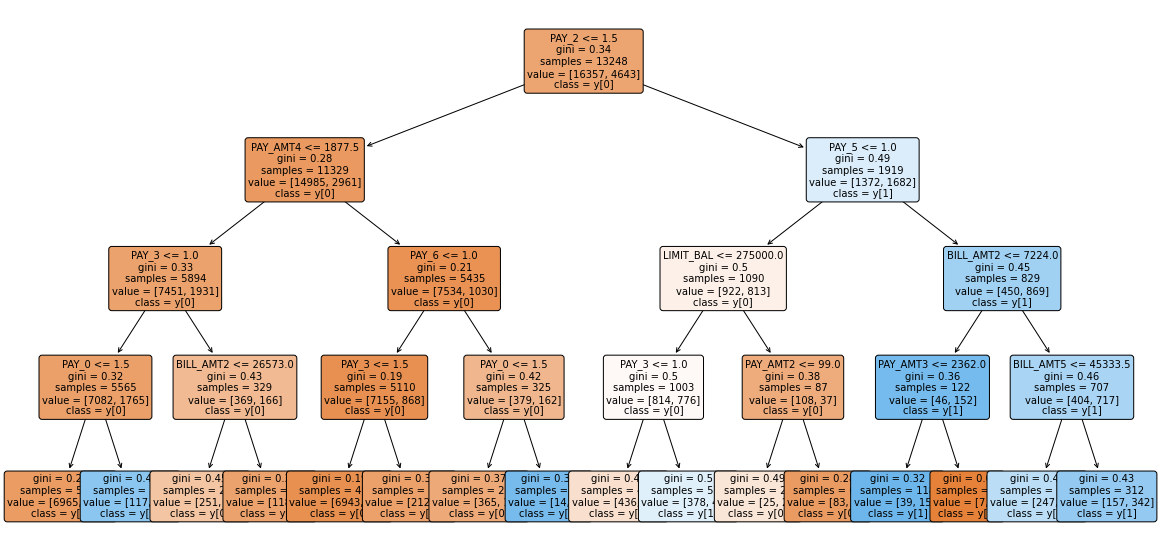

In [112]:
from sklearn.tree import plot_tree

plot_tree(chosen_tree,feature_names = original_variables, class_names = True,
                rounded = True, proportion = False, precision = 2, filled = True, fontsize=10)

## Introducing Hyperparameters

In the previous chapter, we learned what parameters are. We will now learn what exactly hyperparameters are, how to find and set them, as well as some tips and tricks for prioritizing our efforts.

Hyperparameters are something that we set before the modeling process begins. We can think of them like the knobs and dials on an old radio. We tune the different dials and buttons and hope that a nice tune comes out.


The algorithm does not learn the value of these during the modeling process. This is the crucial differentiator between hyperparameters and parameters, whether we set it or the algorithm learns it.

**Hyperparameters in Random Forest**

We can easily see the hyperparameters by creating an instance of the estimator and printing it out. Here we create the estimator with default settings and call the print function on our estimator.

```
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
print(rf_clf)

> RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=10,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False)
```

Those are all our different knobs and dials we can set for our model. There are a lot! But what do they all mean? For this we need to turn to the Scikit Learn documentation.

Let us take the example of the `'n_estimators'` hyperparameter. We can see in the documentation that it tells us the data type and the default value. And it also provides a definition of what it means.

Data Types & Default Value:

```
n_estimators: integer, optional (default=10)
```

Definition:

```
The number of trees in the forest.
```

**Setting hyperparameters**

We can set the hyperparameters when we create the estimator object. The default number of trees seems a little low, so let us set that to be 100 (***it actually 100 as default now***). Whilst we are at it, let us also set the criterion to be `'entropy'`.

```
rf_clf = RandomForestClassifier(n_estimators=100, criterion='entropy')
```

If we print out the model We can see the other default values remain the same, but those we set explicitly overrode the default values.

```
print(rf_clf)

> RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='entropy', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False)
```

**Hyperparameters in Logistic Regression**

What about our logistic regression model, what were the hyperparameters for that? We follow the same steps. Firstly we create a logistic regression estimator. 

```
log_reg_clf = LogisticRegression()
```

Then we print it out

```
print(log_reg_clf)

> LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False)
```

We can see there are less hyperparameters for this model than for the Random Forest.

**Hyperparameter Importance**

Some are more important than others. But before we outline important ones, there are some hyperparameters that definitely will *not* help model performance. These are related to computational decisions or what information to retain for analysis.

With the random forest classifier, these hyperparameters will not assist model performance: 

* `n_jobs`: how many cores to use will only speed up modeling time. 
* `random_state` & `verbose`: a random seed and whether to print out information as the modeling occurs also won't assist.

Hence some hyperparameters we don't need to `'train'` during our work.

**Random Forest: Important Hyperparameters**

There are some generally accepted important hyperparameters to tune for a Random Forest model:

* `n_estimators` (how many trees in the forest) should be set to a high value, 500 or 1000 or even more is not uncommon (noting that there are computational costs to higher values).
* `max_features` controls how many features to consider when splitting, which is vital to ensure tree diversity.
* `max_depth` & `min_sample_leaf` control overfitting of individual trees
* `'criterion'` hyperparameter may have a small impact but it is not generally a primary hyperparameter to consider. 

Remember, this is just a guide and our particular problem may require attention on other hyperparameters.

There are hundreds of machine learning algorithms out there and learning which hyperparameters matter is knowledge we will build over time from a variety of sources. 

For example, there are some great academic papers where people have tried many combinations of hyperparameters for a specific algorithm on many datasets. These can be a very informative read!

We can also find great blogs and tutorials online and consult the Scikit Learn documentation. Of course, one of the best ways to learn is just more practical experience! 


It is important we research this ourselves to build our knowledge base for efficient modeling. Let's explore some hyperparameters in the examples!

### Hyperparameters in Random Forests

As we saw, there are many different hyperparameters available in a Random Forest model using Scikit Learn. Let's try to differentiate between a hyperparameter and a parameter, and easily check whether something is a hyperparameter.

We can create a random forest estimator from the imported Scikit Learn package. Then print this estimator out to see the hyperparameters and their values.

Which of the following is a hyperparameter for the Scikit Learn random forest model?

In [113]:
rf_clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

**Possible Answers**

1. `oob_score`
2. `classes_`
3. `trees`
4. `random_level`

In [114]:
# Pass 1,2,3 or 4 as argument
utils.which_is_hyperparam()

Enter 1, 2, 3 or 4 as the answer


### Exploring Random Forest Hyperparameters

Understanding what hyperparameters are available and the impact of different hyperparameters is a core skill for any data scientist. As models become more complex, there are many different settings we can set, but only some will have a large impact on our model.

We will now assess an existing random forest model (it has some bad choices for hyperparameters!) and then make better choices for a new random forest model and assess its performance.

In [115]:
rf_clf_bad = RandomForestClassifier(n_estimators=5, random_state=42)
rf_clf_bad.fit(X_train, y_train)
rf_bad_predictions = rf_clf_bad.predict(X_test)

In [116]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Get confusion matrix & accuracy for the bad rf_model
print(f'Confusion Matrix: \n\n {confusion_matrix(y_test, rf_bad_predictions)} \n Accuracy Score: \n\n {accuracy_score(y_test, rf_bad_predictions)}')

Confusion Matrix: 

 [[6340  669]
 [1260  731]] 
 Accuracy Score: 

 0.7856666666666666


In [117]:
# Create a new random forest classifier with better hyperparamaters
rf_clf_new = RandomForestClassifier(n_estimators=500, random_state=42)

In [118]:
# Fit this to the data and obtain predictions
rf_new_predictions = rf_clf_new.fit(X_train, y_train).predict(X_test)

In [119]:
# Get confusion matrix & accuracy for the new rf_model
print(f'Confusion Matrix: \n\n {confusion_matrix(y_test, rf_new_predictions)} \n Accuracy Score: \n\n {accuracy_score(y_test, rf_new_predictions)}')

Confusion Matrix: 

 [[6601  408]
 [1253  738]] 
 Accuracy Score: 

 0.8154444444444444


We got a nice 3% accuracy boost just from changing the `n_estimators`. We have had our first taste of hyperparameter tuning for a random forest model.

### Hyperparameters of KNN

The k-nearest-neighbors algorithm is not as popular as it used to be, but can still be an excellent choice for data that has groups of data that behave similarly. Could this be the case for our credit card users?

In this case we will try out several different values for one of the core hyperparameters for the knn algorithm and compare performance.

In [120]:
from sklearn.neighbors import KNeighborsClassifier

# Build a knn estimator for each value of n_neighbours
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_10 = KNeighborsClassifier(n_neighbors=10)
knn_20 = KNeighborsClassifier(n_neighbors=20)

In [121]:
# Fit each to the training data & produce predictions
knn_5_predictions = knn_5.fit(X_train, y_train).predict(X_test)
knn_10_predictions = knn_10.fit(X_train, y_train).predict(X_test)
knn_20_predictions = knn_20.fit(X_train, y_train).predict(X_test)

In [122]:
# Get an accuracy score for each of the models
knn_5_accuracy = accuracy_score(y_test, knn_5_predictions)
knn_10_accuracy = accuracy_score(y_test, knn_10_predictions)
knn_20_accuracy = accuracy_score(y_test, knn_20_predictions)

print(f"The accuracy of 5, 10, 20 neighbours was {knn_5_accuracy}, {knn_10_accuracy}, {knn_20_accuracy}")

The accuracy of 5, 10, 20 neighbours was 0.7527777777777778, 0.7741111111111111, 0.7774444444444445


We succesfully tested 3 different options for 1 hyperparameter, but it was pretty exhausting. Next, we will try to find a way to make this easier.

## Setting & Analyzing Hyperparameter Values

In this chapter we will look more in depth at what values to set for different hyperparameters and begin automating our work.

Previously we learned that some hyperparameters are likely better to start our tuning with than others. What we didn't discuss was what values should we try. This will be specific to the algorithm and to the hyperparameter itself but there does exist best practice around this.

Let's walk through some top tips for deciding ranges of values to try for different hyperparameters.

**Conflicting Hyperparameter Choices**

It is firstly important to know what values ***NOT*** to set as they may conflict.

We will see in the Scikit Learn documentation for the Logistic Regression Algorithm, that some values of the hyperparameter `'penalty'` conflict with some values of the hyperparameter `'solver'`. 

```
The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.
```

Another example from the `ElasticNet` algorithm demonstrates a softer conflict that will not result in an error, but may result in a model construction we had not anticipated.

```
This parameter is ignored when fit_intercept is set to False.
```

Safe to say, close inspection of the Scikit Learn documentation is important. 

**Silly Hyperparamter Values**

There are also values for different hyperparameters that may be valid but are very unlikely to yield good results. Some examples of this are:

* Having a random forest algorithm with a very low number of trees. Would we consider it a forest if it had 2 trees? How about 5 or 10? Still probably not. But at 300, 500, 1000 or more that is definitely getting there!
* Having only 1 neighbor in a K-nearest neighbor algorithm. This algorithm averages votes of `'neighbors'` to our sample. Safe to say averaging the vote of 1 person doesn't sound robust!
* Finally, incrementing some hyperparameters by a small amount is unlikely to greatly improve the model. One more tree in a forest for example, isn't likely to have a large impact. 

Researching and documenting sensible values for different hyperparameters and algorithms will be a very useful activity.

In a previous example we built several different models to test a single hyperparameter like so. 

```
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_10 = KNeighborsClassifier(n_neighbors=10)
knn_20 = KNeighborsClassifier(n_neighbors=20)
```

This was quite an inefficient way of writing code, and we can do better to test different values for the number of neighbors hyperparameter.

**Automating Hyperparameter Tuning**

One thing we could try is using a for loop. We create a list of values to test. Then loop through the list, creating an estimator, fitting and predicting each time. We append the accuracy to a list of accuracy scores to analyze after. 

```
neighbors_list = [3,5,10,20,50,75]

for test_number in neighbors_list:
    model = KNeighborsClassifier(n_neighbors=test_number)
    predictions = model.fit(X_train, y_train).predict(X_test)
    
    accuracy = accuracy_score(y_test, predictions)
    accuracy_list.append(accuracy)
```

This method easily allows us to test more values than our previous work. We can store the results in a DataFrame to view the effect of this hyperparameter on the accuracy of the model.

```
results_df = pf.DataFrame({'neighbors': neighbors_list, 'accuracy': accuracy_list})
print(results_df)
```

| Neighbors | Accuracy  |
| --------: | --------: |
| 3         | 0.71      |
| 5         | 0.7125    |
| 10        | 0.765     |
| 20        | 0.7825    |
| 50        | 0.7825    |
| 75        | 0.7825    |

It appears that adding any more neighbors doesn't help beyond 20.

**Learning Curves**

A common tool that is used to assist with analyzing the impact of a singular hyperparameter on an end result is called a `'learning curve'`.

Firstly let's create a list of many more values to test using Python's range function. The rest of the code is the same
as before. 

```
neighbors_list = list(range(5,500,5))

for test_number in neighbors_list:
    model = KNeighborsClassifier(n_neighbors=test_number)
    predictions = model.fit(X_train, y_train).predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    accuracy_list.append(accuracy)
    
results_df = pf.DataFrame({'neighbors': neighbors_list, 'accuracy': accuracy_list})   
```

Since we tested so many values, we will use a graph rather than a table to analyze the results. We plot the accuracy score on the Y axis and our hyperparameter value on our X axis. 

```
plt.plot(results_df['neighbors'], results_df['accuracy'])

# Add the labels and title
plt.gca().set(xlabel='n_neighbors', ylabel='Accuracy', title='Accuracy for different n_neighbors')
plt.show()
```

![Learning curves](https://github.com/ML-Challenge/week5-preprocessing-and-tunning/blob/master/assets/2-3.png?raw=1)

We can see our suspicions confirmed, that accuracy does not increase at all beyond where we tested before.

One thing to be aware of is that python's range function does not work for decimal steps which is important for hyperparameters that work on that scale. A handy trick uses NumPy's `linspace` function that will create a number of values, evenly spread between a start and end value that we specify.

Here is a quick example, 5 values, evenly spaced between 1 and 2 inclusive:

```
print(np.linspace(1,2,5))

> [1. 1.25 1.5 1.75 2.]
```

Let's practice trying different hyperparameters and plotting some learning curves!

### Automating Hyperparameter Choice

Finding the best hyperparameter of interest without writing hundreds of lines of code for hundreds of models is an important efficiency gain that will greatly assist our future machine learning model building.

An important hyperparameter for the GBM algorithm is the learning rate. But which learning rate is best for this problem? By writing a loop to search through a number of possibilities, collating these and viewing them we can find the best one.

Possible learning rates to try include 0.001, 0.01, 0.05, 0.1, 0.2 and 0.5

In [123]:
from sklearn.ensemble import GradientBoostingClassifier

In [124]:
# Set the learning rates & results storage
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]
results_list = []

In [125]:
# Create the for loop to evaluate model predictions for each learning rate
for learning_rate in learning_rates:
    model = GradientBoostingClassifier(learning_rate=learning_rate, random_state=42)
    predictions = model.fit(X_train, y_train).predict(X_test)
    # Save the learning rate and accuracy score
    results_list.append([learning_rate, accuracy_score(y_test, predictions)])

In [126]:
# Gather everything into a DataFrame
results_df = pd.DataFrame(results_list, columns=['learning_rate', 'accuracy'])
print(results_df)

   learning_rate  accuracy
0          0.001  0.778778
1          0.010  0.817556
2          0.050  0.817889
3          0.100  0.817000
4          0.200  0.815667
5          0.500  0.811111


We efficiently tested a few different values for a single hyperparameter and can easily see which learning rate value was the best. Here, it seems that a learning rate of 0.05 yields the best accuracy.

### Building Learning Curves

If we want to test many different values for a single hyperparameter it can be difficult to easily view that in the form of a DataFrame. Previously we learned about a nice trick to analyze this. A graph called a 'learning curve' can nicely demonstrate the effect of increasing or decreasing a particular hyperparameter on the final result.

Instead of testing only a few values for the learning rate, we will test many to easily see the effect of this hyperparameter across a large range of values. A useful function from NumPy is `np.linspace(start, end, num)` which allows us to create a number of values (`num`) evenly spread within an interval (`start`, `end`) that we specify.

In [127]:
# Set the learning rates & accuracies list
learn_rates = np.linspace(0.01, 2, num=30)
accuracies = []

In [128]:
# Create the for loop
for learn_rate in learn_rates:
    # Create the model, predictions & save the accuracies as before
    model = GradientBoostingClassifier(learning_rate=learn_rate, random_state=42)
    predictions = model.fit(X_train, y_train).predict(X_test)
    accuracies.append(accuracy_score(y_test, predictions))

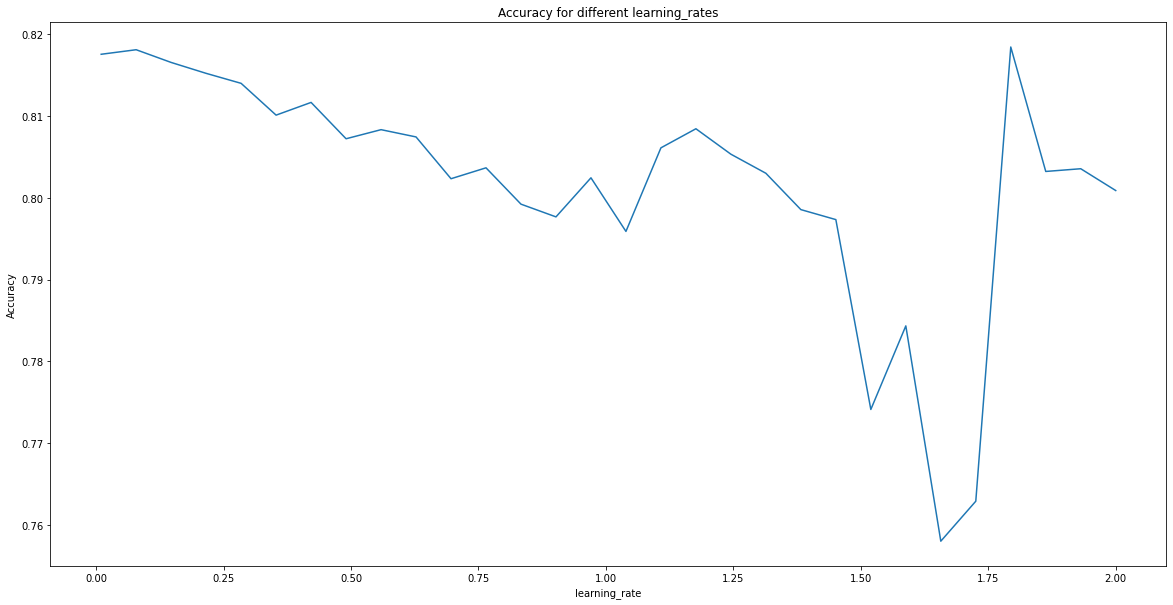

In [129]:
# Plot results    
plt.plot(learn_rates, accuracies)
plt.gca().set(xlabel='learning_rate', ylabel='Accuracy', title='Accuracy for different learning_rates')
plt.show() 

We can see that for low values, we get a pretty good accuracy. However once the learning rate pushes much above 1.5, the accuracy starts to drop. We have learned and practiced a useful skill for visualizing large amounts of results for a single hyperparameter.

# Grid search

This part of the lesson introduces a popular automated hyperparameter tuning methodology called Grid Search. We will learn what it is, how it works and practice undertaking a Grid Search using Scikit Learn. We will then learn how to analyze the output of a Grid Search & gain practical experience doing this.

## Introducing Grid Search

In this section we will look at extending our work on automatic hyperparameter tuning and learn what a Grid Search is.

Let's remind ourselves of our previous work using a for loop to test different values of the number of neighbors in a KNN algorithm. We then collated those into a DataFrame to analyze. 

But what if we want to test different values of 2 hyperparameters? Let us take the example of a GBM algorithm, which has a few more hyperparameters to tune than KNN or Random Forest algorithms. Let's' say we want to tune the two hyperparameters and values as follows:

* `learn_rate` - [0.001, 0.01, 0.05]
* `max_depth` - [4,6,8,10]

How would we do that? One suggestion could be a nested loop. With a nested loop we test all values of our first hyperparameter for all values of our second hyperparameter.

**How many models**

We will notice that many more models are built when adding more hyperparameters and values to test. Importantly, this relationship between models created and hyperparameters or values to test is not a linear relationship, it is exponential. For each of the values tested for the first hyperparameter, we test every value of the second hyperparameter.

This means to test 5 values for the first hyperparameter and 10 values for the second hyperparameter, we have 50 models to run. And what if we k-fold cross-validated each model 10 times? That would be 500 models to run! That was just for 2 hyperparameters. What if we wanted to test a third or fourth hyperparameter? We could nest again (and again). 

Safe to say we cannot keep nesting forever as our code becomes complex and inefficient. Plus, what if we also wanted some extra information on training and testing times and scores. Our code will get quite complex.

Let's review our work in an alternate way. If we created a grid with each value of `max_depth` that we want to test down the left and each value of `learning_rate` across the top. The intersection square of each of these is a model that we need to run. 

![Grid Search](https://github.com/ML-Challenge/week5-preprocessing-and-tunning/blob/master/assets/2-12.png?raw=1)


Running a model for every cell in the grid with the hyperparameters specified is known as a `Grid Search`.

Grid search has a number of advantages:

* It's programmatic, and saves many lines of code.
* It is guaranteed to find the best model within the grid we specify. But if we specify a poor grid with silly or
conflicting values we won't get a good score!
* Finally, it is an easy methodology to explain

However there are some disadvantages to this approach: 
* It is computationally expensive. 
* It is also 'uninformed' because it doesn't learn as it creates models the next model it creates could be better or worse.

Let's now practice undertaking a grid search!

### Build Grid Search functions

In data science it is a great idea to try building algorithms, models and processes 'from scratch' so we can really understand what is happening at a deeper level. Of course there are great packages and libraries for this work (and we will get to that very soon!) but building from scratch will give us a great edge in our data science work.

In this example, we will create a function to take in 2 hyperparameters, build models and return results. We will use this function in a future example.

In [130]:
# Create the function
def gbm_grid_search(learn_rate, max_depth, random_state=42):

    # Create the model
    model = GradientBoostingClassifier(learning_rate=learn_rate, max_depth=max_depth, random_state=random_state)
    
    # Use the model to make predictions
    predictions = model.fit(X_train, y_train).predict(X_test)
    
    # Return the hyperparameters and score
    return([learn_rate, max_depth, accuracy_score(y_test, predictions)])

### Iteratively tune multiple hyperparameters

In this example, we will build on the function we previously created to take in 2 hyperparameters, build a model and return the results. We will now use that to loop through some values and then extend this function and loop with another hyperparameter.

In [131]:
# Create the relevant lists
results_list = []
learn_rate_list = [0.01, 0.1, 0.5]
max_depth_list = [2,4,6]

In [132]:
# Create the for loop
for learn_rate in learn_rate_list:
    for max_depth in max_depth_list:
        results_list.append(gbm_grid_search(learn_rate,max_depth))

In [133]:
# Print the results
results_list

[[0.01, 2, 0.8172222222222222],
 [0.01, 4, 0.8171111111111111],
 [0.01, 6, 0.8157777777777778],
 [0.1, 2, 0.8167777777777778],
 [0.1, 4, 0.8174444444444444],
 [0.1, 6, 0.8154444444444444],
 [0.5, 2, 0.814],
 [0.5, 4, 0.7998888888888889],
 [0.5, 6, 0.787]]

In [134]:
# Extend the function input
def gbm_grid_search_extended(learn_rate, max_depth, subsample, random_state=42):

    # Extend the model creation section
    model = GradientBoostingClassifier(learning_rate=learn_rate, max_depth=max_depth, subsample=subsample, random_state=42)
    
    predictions = model.fit(X_train, y_train).predict(X_test)
    
    # Extend the return part
    return([learn_rate, max_depth, subsample, accuracy_score(y_test, predictions)])

In [135]:
results_list = []

# Create the new list to test
subsample_list = [0.4, 0.6]

In [136]:
for learn_rate in learn_rate_list:
    for max_depth in max_depth_list:
        # Extend the for loop
        for subsample in subsample_list:
            # Extend the results to include the new hyperparameter
            results_list.append(gbm_grid_search_extended(learn_rate, max_depth, subsample))

In [137]:
# Print results
results_list

[[0.01, 2, 0.4, 0.8171111111111111],
 [0.01, 2, 0.6, 0.817],
 [0.01, 4, 0.4, 0.8174444444444444],
 [0.01, 4, 0.6, 0.8164444444444444],
 [0.01, 6, 0.4, 0.8156666666666667],
 [0.01, 6, 0.6, 0.8162222222222222],
 [0.1, 2, 0.4, 0.8162222222222222],
 [0.1, 2, 0.6, 0.817],
 [0.1, 4, 0.4, 0.814],
 [0.1, 4, 0.6, 0.8148888888888889],
 [0.1, 6, 0.4, 0.8114444444444444],
 [0.1, 6, 0.6, 0.8157777777777778],
 [0.5, 2, 0.4, 0.815],
 [0.5, 2, 0.6, 0.8144444444444444],
 [0.5, 4, 0.4, 0.7958888888888889],
 [0.5, 4, 0.6, 0.7985555555555556],
 [0.5, 6, 0.4, 0.7686666666666667],
 [0.5, 6, 0.6, 0.782]]

We have effectively built our own grid search! We went from 2 to 3 hyperparameters and can see how we could extend that to even more values and hyperparameters. That was a lot of effort though. Be warned - we are now entering a world that can get very computationally expensive very fast!

### How Many Models?

Adding more hyperparameters or values, we increase the amount of models created but the increase is not linear, it is proportional to how many values and hyperparameters we already have.

How many models would be created when running a grid search over the following hyperparameters and values for a GBM algorithm?

* learning_rate = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2]
* max_depth = [4,6,8,10,12,14,16,18, 20]
* subsample = [0.4, 0.6, 0.7, 0.8, 0.9]
* max_features = ['auto', 'sqrt', 'log2']

**Possible Answers**

1. 26
2. 9 of one model, 9 of another
3. 1 large model
4. 1215

In [138]:
# Enter 1, 2, 3 or 4 as the answer
utils.how_many_models()

Enter 1, 2, 3 or 4 as the answer


## Grid Search with Scikit Learn

In this chapter we will move beyond our manual code and leverage Scikit Learn's `GridSearchCV` to assist our grid search. It will help us create a grid search more efficiently and get some performance analytics.

This is an example of a GridSearchCV object: 

```
sklearn.model_selection.GridSearchCV(
    estimator,
    param_grid, scoring=None, fit_params=None,
    n_jobs=None, iid='warm', refit=True, cv='warn,
    verbose=0, pre_dispatch='2*n_jobs',
    error_score='raise-deprecating',
    return_train_score='warn')
```

Don't worry, we will break it down!

**Steps in a Grid Search**

Firstly, let us conceptualize the steps needed to do a proper grid search. Some of these will be familiar from our manual work before:

1. Select an algorithm (or 'estimator') to tune
2. Define which hyperparameters we will tune
3. Define a range of values for each hyperparameter
4. Decide a cross-validation scheme
5. Define a scoring function to determine which model was the best
6. Include extra useful information or functions.

The only one of these we did not do much work with previously is step (4), but we will cover each now.

**GridSearchCV Object Inputs**

A GridSearchCV object takes several important arguments:

* estimator
* param_grid
* cv
* scoring
* refit
* n_jobs
* return_train_score

The `estimator` is our algorithm. Examples include KNN, Random Forest, GBM or Logistic Regression. We only pick one algorithm for each grid search.

`param_grid` is how we tell GridSearchCV which hyperparameters and which values to test. We were previously using lists, but param_grid needs a dictionary. The dictionary keys must be the hyperparameter names, the values a list of values to test. The keys in the param_grid dictionary must be valid hyperparameters else the Grid Search will fail.

```
param_grid = { 'max_depth': [2, 4, 6, 8],
               'min_samples_leaf': [1, 2, 4, 6]}
```

The `cv` input allows us to undertake cross-validation. We could specify different cross-validation types here. But simply providing an integer will create a k-fold. We are likely familiar with standard 5 and 10 k-fold cross validation.

![k-fold](https://github.com/ML-Challenge/week5-preprocessing-and-tunning/blob/master/assets/2-4.png?raw=1)

`scoring` is a scoring function used to evaluate our model's performance. We did this manually previously using accuracy. We can use our own custom metric, or one from the available metrics from Scikit Learn's `metrics` module. We can check all available metrics using this command:

```
from sklearn import metrics
sorted(metris.SCORERS.keys())
```

`refit` set to true means the best hyperparameter combinations are used to undertake a fitting to the training data. The GridSearchCV object can be used as an estimator directly. This is very handy as we don't need to save our the best hyperparameters and train another model.

`n_jobs` assists with parallel execution. We can effectively 'split up' our work and have many models being created at the same time. This is possible because the results of one model do not affect the next one. We can check how many cores we have available, which determines how many models we can run in parallel using this handy code:

```
import os
print(os.cpu_count())
```

We must be careful using all cores for a task though as this may mean we can't do other work on our computer while our models run.

Finally `return_train_score` logs statistics about the training runs that were undertaken. This can be useful for plotting and understanding test vs training set performance (and hence bias-variance tradeoff). While informative, this is computationally expensive and will not assist in finding the best model.


Now we have all the components to build a grid search object!

### GridSearchCV inputs

Let's test our knowledge of GridSeachCV inputs by answering the question below.

Three GridSearchCV objects are available below. Note that there is no data available to fit these models. Instead, answer by looking at their construct.

```
Model #1:
 GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': [2, 4, 8, 15], 'max_features': ['auto', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0) 


Model #2:
 GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'n_neighbors': [5, 10, 20], 'algorithm': ['ball_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='accuracy', verbose=0) 


Model #3:
 GridSearchCV(cv=7, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'number_attempts': [2, 4, 6], 'max_depth': [3, 6, 9, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)
```

Which of these GridSearchCV objects would not work when we try to fit it?

**Possible Answers**

1. `Model #1` would not work when we try to fit it.
2. `Model #2` would not work when we try to fit it.
3. `Model #3` would not work when we try to fit it.
4. None - they will all work when we try to fit them.

In [139]:
# Enter 1, 2, 3 or 4 as the answer
utils.which_grid_search()

Enter 1, 2, 3 or 4 as the answer


### GridSearchCV with Scikit Learn

The `GridSearchCV` module from Scikit Learn provides many useful features to assist with efficiently undertaking a grid search. We will now put it into practice by creating a GridSearchCV object with certain parameters.

The desired options are:

* A Random Forest Estimator, with the split criterion as 'entropy'
* 5-fold cross validation
* The hyperparameters `max_depth` (2, 4, 8, 15) and `max_features` ('auto' vs 'sqrt')
* Use `roc_auc` to score the models
* Use 4 cores for processing in parallel
* Ensure we refit the best model and return training scores

In [140]:
# Create a Random Forest Classifier with specified criterion
rf_class = RandomForestClassifier(criterion='entropy', random_state=42)

In [141]:
# Create the parameter grid
param_grid = {'max_depth': [2, 4, 8, 15], 'max_features': ['auto', 'sqrt']}

In [142]:
# Create a GridSearchCV object
from sklearn.model_selection import GridSearchCV

grid_rf_class=GridSearchCV(
    estimator=rf_class,
    param_grid=param_grid,
    scoring='roc_auc',
    n_jobs=4,
    cv=5,
    refit=True, 
    return_train_score=True)

grid_rf_class

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, ra

## Understanding a grid search output

Now that we know how to run a grid search, let's focus on its output. Let us now analyze each of the properties of the GridSearchCV output and learn how to access and use them. The properties of the object can be categorized into three different groups:

* a results log: `cv_results_`
* the best results: `best_index_`, `best_params_` & `best_index_`
* 'Extra information': `scorer_`, `n_splits_` & `refit_time_`

Properties are accessed using the dot notation, that is `grid_search_object.property`. Where `property` is the actual property we want to retrieve.

Let's review each of the key properties now:

Firstly there is the `cv_results_` property. This is a dictionary that we can read into a pandas DataFrame to explore.

The `param_` columns contain information on the different parameters that were used in the model. 

![CV Results](https://github.com/ML-Challenge/week5-preprocessing-and-tunning/blob/master/assets/2-14.png?raw=1)

Remember, each row in this DataFrame is about one model. So we can see row 3 for example tested the hyperparameter combination of `max_depth=10` ,`min_samples_leaf=2` nd `n_estimators=100` for our random forest estimator. 

The `params` column is a dictionary of all the parameters from the previous `'param'` columns.

![Params](https://github.com/ML-Challenge/week5-preprocessing-and-tunning/blob/master/assets/2-15.png?raw=1)

We need to use `pd.set_option` here to ensure we don't truncate the results we are printing:

```
pd.set_option('display.max_colwidth', -1)
print(cv_results_df.loc[:, 'params'])
```

The next 5 columns are the testing scores for each of the 5 cross-folds, or splits, we made, followed by the the mean and standard deviation for those cross-folds. 

![CV Results](https://github.com/ML-Challenge/week5-preprocessing-and-tunning/blob/master/assets/2-13.png?raw=1)

The rank column conveniently ranks the rows by the `mean_test_score`.

![Params](https://github.com/ML-Challenge/week5-preprocessing-and-tunning/blob/master/assets/2-16.png?raw=1)

We can see that the model in our third row had the best mean_test_score.

Using the `rank_test_score` column we can easily select the grid search square for analysis. 


```
best_row = cv_results_df[cv_results_df['rank_test_score'] == 1]
prnt(best_row)
```

![Params](https://github.com/ML-Challenge/week5-preprocessing-and-tunning/blob/master/assets/2-17.png?raw=1)

This table is the row from the `cv_results` object that was the best model created. 

The `test_score` columns are then repeated for the training scores. Note that if we had not set `return_train_score` to True this would not include the training scores. There is also no ranking column for the training scores, as we only care about performance on the test set in each fold.

Information on the best grid square is found in three different properties:

* `best_params_` which is the dictionary of the parameters that gave the best score. 
* `best_score_`, the actual best score 
* `best_index`, the row in our `cv_results_` that was the best. This is same as the index of the row with rank 1 in cv_results_ that we extracted just before.

GridSearchCV stores an estimator built with the best hyperparameters in the `best_estimator_` property. Since it is an estimator, we can use this to predict on our test set.

We can also use the GridSearchCV object itself directly as an estimator. This is why we set refit=True when creating the grid search, otherwise we would need to refit using the best parameters ourself before using the best estimator.

**Extra information**

Some extra information can be obtained with the following properties. These are not very useful properties but may be important if we construct our grid search differently

These include the scorer function that was used and the number of cross validation splits (both of which we set ourselves), and the refit_time which is the number of seconds used for refitting the best model on the whole dataset. 

This may be of interest in analyzing efficiencies in our work, but not for our use case here.

### Exploring the grid search results

We will now explore the `cv_results_` property of the GridSearchCV object defined above. This is a dictionary that we can read into a pandas DataFrame and contains a lot of useful information about the grid search we just undertook.

A reminder of the different column types in this property:

* `time_` columns
* `param_` columns (one for each hyperparameter) and **the** singular `params` column (with all hyperparameter settings)
* a `train_score` column for each cv fold including the `mean_train_score` and `std_train_score` columns
* a `test_score` column for each cv fold including the `mean_test_score` and `std_test_score` columns
* a `rank_test_score` column with a number from 1 to n (number of iterations) ranking the rows based on their `mean_test_score`

In [143]:
# First fit the GridSearchCV
grid_rf_class.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, ra

In [144]:
# Read the cv_results property into a dataframe & print it out
cv_results_df = pd.DataFrame(grid_rf_class.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.413798,0.040333,0.103751,0.005252,2,auto,"{'max_depth': 2, 'max_features': 'auto'}",0.785047,0.781114,0.756124,0.743269,0.781595,0.769430,0.016672,7,0.771513,0.768053,0.775149,0.777181,0.771317,0.772643,0.003193
1,3.438284,0.154910,0.104722,0.008429,2,sqrt,"{'max_depth': 2, 'max_features': 'sqrt'}",0.785047,0.781114,0.756124,0.743269,0.781595,0.769430,0.016672,7,0.771513,0.768053,0.775149,0.777181,0.771317,0.772643,0.003193
2,5.950939,0.228475,0.115280,0.034199,4,auto,"{'max_depth': 4, 'max_features': 'auto'}",0.787020,0.787569,0.761032,0.748676,0.786546,0.774169,0.016250,5,0.778370,0.777638,0.784004,0.786128,0.779058,0.781040,0.003385
3,5.921120,0.127458,0.113182,0.004088,4,sqrt,"{'max_depth': 4, 'max_features': 'sqrt'}",0.787020,0.787569,0.761032,0.748676,0.786546,0.774169,0.016250,5,0.778370,0.777638,0.784004,0.786128,0.779058,0.781040,0.003385
4,10.912080,0.087753,0.148159,0.002345,8,auto,"{'max_depth': 8, 'max_features': 'auto'}",0.793212,0.794749,0.766462,0.757675,0.791642,0.780748,0.015534,1,0.825088,0.829276,0.832937,0.835633,0.828782,0.830343,0.003631
5,10.928758,0.054706,0.146998,0.004165,8,sqrt,"{'max_depth': 8, 'max_features': 'sqrt'}",0.793212,0.794749,0.766462,0.757675,0.791642,0.780748,0.015534,1,0.825088,0.829276,0.832937,0.835633,0.828782,0.830343,0.003631
6,18.390711,0.124532,0.210484,0.028196,15,auto,"{'max_depth': 15, 'max_features': 'auto'}",0.789223,0.795596,0.766288,0.759521,0.788907,0.779907,0.014248,3,0.974664,0.975878,0.975543,0.975847,0.974644,0.975315,0.000553
7,16.612346,2.430838,0.164943,0.048773,15,sqrt,"{'max_depth': 15, 'max_features': 'sqrt'}",0.789223,0.795596,0.766288,0.759521,0.788907,0.779907,0.014248,3,0.974664,0.975878,0.975543,0.975847,0.974644,0.975315,0.000553


In [145]:
# Extract and print the column with a dictionary of hyperparameters used
column = cv_results_df.loc[:, ["params"]]
column

,params
0,"{'max_depth': 2, 'max_features': 'auto'}"
1,"{'max_depth': 2, 'max_features': 'sqrt'}"
2,"{'max_depth': 4, 'max_features': 'auto'}"
3,"{'max_depth': 4, 'max_features': 'sqrt'}"
4,"{'max_depth': 8, 'max_features': 'auto'}"
5,"{'max_depth': 8, 'max_features': 'sqrt'}"
6,"{'max_depth': 15, 'max_features': 'auto'}"
7,"{'max_depth': 15, 'max_features': 'sqrt'}"


In [146]:
# Extract and print the row that had the best mean test score
best_row = cv_results_df[cv_results_df["rank_test_score"] == 1]
best_row

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
4,10.912080,0.087753,0.148159,0.002345,8,auto,"{'max_depth': 8, 'max_features': 'auto'}",0.793212,0.794749,0.766462,0.757675,0.791642,0.780748,0.015534,1,0.825088,0.829276,0.832937,0.835633,0.828782,0.830343,0.003631
5,10.928758,0.054706,0.146998,0.004165,8,sqrt,"{'max_depth': 8, 'max_features': 'sqrt'}",0.793212,0.794749,0.766462,0.757675,0.791642,0.780748,0.015534,1,0.825088,0.829276,0.832937,0.835633,0.828782,0.830343,0.003631


### Analyzing the best results

At the end of the day, we primarily care about the best performing 'square' in a grid search. Luckily Scikit Learn's `gridSearchCV` objects have a number of parameters that provide key information on just the best square (or row in `cv_results_`).

Three properties we will explore are:

* `best_score_` – The score (here ROC_AUC) from the best-performing square.
* `best_index_` – The index of the row in `cv_results_` containing information on the best-performing square.
* `best_params_` – A dictionary of the parameters that gave the best score, for example `'max_depth': 10`

In [147]:
# Print out the ROC_AUC score from the best-performing square
best_score = grid_rf_class.best_score_
best_score

0.7807478974147012

In [148]:
# Create a variable from the row related to the best-performing square
cv_results_df = pd.DataFrame(grid_rf_class.cv_results_)
best_row = cv_results_df.loc[[grid_rf_class.best_index_]]
best_row

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
4,10.91208,0.087753,0.148159,0.002345,8,auto,"{'max_depth': 8, 'max_features': 'auto'}",0.793212,0.794749,0.766462,0.757675,0.791642,0.780748,0.015534,1,0.825088,0.829276,0.832937,0.835633,0.828782,0.830343,0.003631


In [149]:
# Get the max_depth parameter from the best-performing square
best_max_depth = grid_rf_class.best_params_["max_depth"]
best_max_depth

8

Being able to quickly find and prioritize the huge volume of information given back from machine learning modeling output is a great skill. Here we had great practice doing that with `cv_results_` by quickly isolating the key information on the best performing square. This will be very important when our grids grow from 12 squares to many more!

### Using the best results

While it is interesting to analyze the results of our grid search, our final goal is practical in nature; we want to make predictions on our test set using our estimator object.

We can access this object through the `best_estimator_` property of our grid search object.

In this example, we will take a look inside the `best_estimator_` property and then use this to make predictions on our test set for credit card defaults and generate a variety of scores. Remember that we need to use `predict_proba` rather than `predict` since we need probability values rather than class labels for our roc_auc score. We use a slice `[:,1]` to get probabilities of the positive class.

In [150]:
# See what type of object the best_estimator_ property is
type(grid_rf_class.best_estimator_)

sklearn.ensemble._forest.RandomForestClassifier

In [151]:
# Create an array of predictions directly using the best_estimator_ property
predictions = grid_rf_class.best_estimator_.predict(X_test)

In [152]:
# Take a look to confirm it worked, this should be an array of 1's and 0's
predictions[0:5]

array([0, 0, 0, 1, 0])

In [153]:
# Now create a confusion matrix 
print("Confusion Matrix \n", confusion_matrix(y_test, predictions))

Confusion Matrix 
 [[6657  352]
 [1297  694]]


In [154]:
from sklearn.metrics import roc_auc_score

# Get the ROC-AUC score
predictions_proba = grid_rf_class.best_estimator_.predict_proba(X_test)[:,1]
print("ROC-AUC Score \n", roc_auc_score(y_test, predictions_proba))

ROC-AUC Score 
 0.7743063933226699


The `.best_estimator_` property is a really powerful property to understand for streamlining our machine learning model building process. We now can run a grid search and seamlessly use the best model from that search to make predictions.

# Random Search

Another popular automated hyperparameter tuning methodology is called Random Search. We will learn what it is, how it works and importantly how it differs from grid search. We will learn some advantages and disadvantages of this method and when to choose this method compared to Grid Search. We will practice undertaking a Random Search with Scikit Learn as well as visualizing & interpreting the output.

## Introducing Random Search

In this chapter we will cover the concept of random search, how it differs from grid search, as well as some advantages and disadvantages of this method.

A random search is very similar to a grid search several key steps. We still define an estimator, which hyperparameters to tune and the range of values for each hyperparameter. Similarly, we still set a cross-validation scheme and scoring function. However when it comes to undertaking the search, rather than trying every single combination, we randomly sample N combinations and try these out. 

This may seem like a really odd thing to do. Why would we do this and why does it work?

An important paper by Yoshua Bengio and James Bergstra outlines that reason that this works can be explained with two fundamental principles:

* Not every hyperparameter is as important (we hinted at this in the Grid Search Section)
* A little trick of probability.

Let's explain the probability trick.

Let's say that we have this grid. It has 100 cells, so 100 different models. 10 different values each of two hyperparameters. Let us say that these 5 models are the best, highlighted in green. 


![Random Search](https://github.com/ML-Challenge/week5-preprocessing-and-tunning/blob/master/assets/2-5.png?raw=1)

How many models would we need to run with random search to have a 95% chance of getting one of the green squares?

Let's consider how likely it is that we continue to completely miss the good models, if we randomly select hyperparameter combinations uniformly:

* On our first trial we have 5% chance of getting one of these squares as it is 5 squares out of 100. Therefore we have `(1-0.05)` chance of missing these squares. 
* If we do a second trial, we now have `(1-0.05) * (1-0.05)` of missing that range. 
* For a third trial we have `(1-0.05) * (1-0.05) * (1-0.05)` chance of missing that range. 

In fact, with n trials we have (1-0.05)^n chance that every single trial misses all the good models. So how many trials to have a high chance of being in the region?

We know that the probability of missing everything is `(1-0.05)^n`. So the probability of getting something in that area must be `1-(miss everything)` which is `1-(1-0.05)^n`. Without going into too much details, we can solve to get the answer as `n >= 59`. So what does that all mean?

With relatively few trials we can get close to our maximum score with a relatively high probability. In essence, it is very unlikely that we will continue to miss everything for a long time. A Grid Search may spend lots of time covering a bad area. 

**Some important notes**

There are some important things to keep in mind with random search. Our possible score is still only as good as the grid we set! If we a bad grid to sample from, we will not get a great model. 

Remember to fairly compare this to grid search, we need to have the same modeling 'budget'. For example, 200 models on grid search and 200 models in random search.

**Creating a random sample of hyperparameters**

We can create our own random sample of hyperparameter combinations. We firstly set the hyperparameter lists as we have done before with numpy linspace and a range function. 

```
# Set some hyperparameter lists
learn_rate_list = np.linspace(0.001, 2, 150)
min_samples_leaf_list = list(range(1, 51))
```

We can then create a single list of hyperparameter combinations that we can sample from using itertools `product` function. 

```
# Create list of combinations
from itertools import product
combinations_list = [list(x) for x in product(learn_rate_list, min_samples_leaf_list)]
```

Then we can randomly select 100 models from these lists using NumPy's handy `random.choice` function, which gives us 100 random
indexes we can use to index into the created list in the last line.

```
# Select 100 models from our larger set
random_combinations_index = np.random.choice(range(0, len(combinations_list)), 100, replace=False)
combinations_random_chosen = [combinations_list[x] for x in random_combinations_index]
```

**Visualizing a Random Search**

A visual inspection of the hyperparameter values chosen by random search is a nice way to demonstrate how it works. 

![Random Search Graph](https://github.com/ML-Challenge/week5-preprocessing-and-tunning/blob/master/assets/2-6.png?raw=1)

Notice how the coverage of this is very wide but it does not cover thoroughly? Let's practice sampling and visualizing our own random search!

### Randomly Sample Hyperparameters

To undertake a random search, we firstly need to undertake a random sampling of our hyperparameter space.

In this example, we will firstly create some lists of hyperparameters that can be zipped up to a list of lists. Then we will randomly sample hyperparameter combinations preparation for running a random search.

We will use just the hyperparameters `learning_rate` and `min_samples_leaf` of the GBM algorithm to keep the example illustrative and not overly complicated.

In [155]:
# Create a list of values for the learning_rate hyperparameter
learn_rate_list = list(np.linspace(0.01,1.5,200))

In [156]:
# Create a list of values for the min_samples_leaf hyperparameter
min_samples_list = list(range(10,41))

In [157]:
# Combination list
from itertools import product
combinations_list = [list(x) for x in product(learn_rate_list, min_samples_list)]

In [158]:
# Sample hyperparameter combinations for a random search.
random_combinations_index = np.random.choice(range(0, len(combinations_list)), 250, replace=False)
combinations_random_chosen = [combinations_list[x] for x in random_combinations_index]

In [159]:
# Print the result
combinations_random_chosen

[[0.8485929648241206, 40],
 [1.2678894472361808, 13],
 [1.0657286432160804, 26],
 [1.3951758793969848, 36],
 [1.1106532663316582, 30],
 [0.668894472361809, 33],
 [0.2421105527638191, 37],
 [0.9908542713567839, 10],
 [0.2570854271356784, 35],
 [1.0432663316582915, 12],
 [0.3768844221105528, 25],
 [0.15974874371859296, 23],
 [1.2304522613065327, 15],
 [0.7287939698492463, 30],
 [0.4742211055276382, 36],
 [0.691356783919598, 12],
 [0.945929648241206, 23],
 [0.12231155778894472, 22],
 [1.2753768844221105, 39],
 [1.1406030150753768, 29],
 [1.222964824120603, 39],
 [0.15226130653266332, 17],
 [0.08487437185929647, 35],
 [1.2154773869346733, 14],
 [0.945929648241206, 40],
 [0.9609045226130652, 32],
 [1.3577386934673366, 36],
 [1.222964824120603, 34],
 [0.7587437185929649, 28],
 [1.4176381909547737, 15],
 [0.8411055276381909, 30],
 [0.6539195979899497, 29],
 [1.29035175879397, 39],
 [1.327788944723618, 15],
 [0.7213065326633166, 36],
 [1.3203015075376885, 24],
 [0.968391959798995, 10],
 [0.152

We generated some hyperparameter combinations and randomly sampled in that space. The output was not too nice though, in the next example we will use a much more efficient method for this. In a future example we will also make this output look much nicer!

### Randomly Search with Random Forest

To solidify our knowledge of random sampling, let's try a similar exercise but using different hyperparameters and a different algorithm.

As before, we create some lists of hyperparameters that can be zipped up to a list of lists. We will use the hyperparameters `criterion`, `max_depth` and `max_features` of the random forest algorithm. Then we will randomly sample hyperparameter combinations in preparation for running a random search.

We will use a slightly different package for sampling in this task, `random.sample()`.

In [160]:
# Create lists for criterion and max_features
criterion_list = ["gini", "entropy"]
max_feature_list = ["auto", "sqrt", "log2", None]

In [161]:
# Create a list of values for the max_depth hyperparameter
max_depth_list = list(range(3,56))

In [162]:
# Combination list
combinations_list = [list(x) for x in product(criterion_list, max_feature_list, max_depth_list)]

In [163]:
import random

# Sample hyperparameter combinations for a random search
combinations_random_chosen = random.sample(combinations_list, 150)

In [164]:
# Print the result
combinations_random_chosen

[['gini', None, 15],
 ['entropy', 'log2', 55],
 ['gini', 'auto', 27],
 ['entropy', 'sqrt', 50],
 ['gini', 'log2', 16],
 ['gini', 'sqrt', 53],
 ['gini', 'sqrt', 43],
 ['gini', 'auto', 45],
 ['entropy', None, 8],
 ['entropy', 'auto', 44],
 ['gini', 'sqrt', 54],
 ['entropy', 'auto', 28],
 ['gini', 'auto', 55],
 ['gini', 'sqrt', 26],
 ['gini', 'auto', 10],
 ['entropy', None, 42],
 ['entropy', None, 49],
 ['entropy', 'auto', 51],
 ['entropy', 'auto', 33],
 ['gini', 'sqrt', 29],
 ['gini', None, 29],
 ['gini', 'log2', 46],
 ['entropy', None, 24],
 ['gini', None, 26],
 ['entropy', 'auto', 43],
 ['gini', 'sqrt', 45],
 ['gini', 'auto', 53],
 ['gini', None, 50],
 ['entropy', 'log2', 39],
 ['gini', 'auto', 13],
 ['gini', 'auto', 18],
 ['entropy', 'sqrt', 25],
 ['entropy', 'sqrt', 7],
 ['gini', 'auto', 12],
 ['gini', None, 8],
 ['gini', 'sqrt', 15],
 ['entropy', 'log2', 6],
 ['gini', 'log2', 29],
 ['gini', 'auto', 21],
 ['gini', None, 40],
 ['gini', 'log2', 37],
 ['gini', 'sqrt', 25],
 ['entropy', 

### Visualizing a Random Search

Visualizing the search space of random search allows us to easily see the coverage of this technique and therefore allows us to see the effect of our sampling on the search space.

In this example we will use several different samples of hyperparameter combinations and produce visualizations of the search space.

In [165]:
def sample_hyperparameters(n_samples):
    global combinations_random_chosen

    if n_samples == len(combinations_list):
        combinations_random_chosen = combinations_list
        return

    combinations_random_chosen = []
    random_combinations_index = np.random.choice(range(0, len(combinations_list)), n_samples, replace=False)
    combinations_random_chosen = [combinations_list[x] for x in random_combinations_index]
    return

In [166]:
def visualize_search():
    rand_y, rand_x = [x[0] for x in combinations_random_chosen], [x[1] for x in combinations_random_chosen]

    # Plot all together
    plt.clf() 
    plt.scatter(rand_y, rand_x, c=['blue']*len(combinations_random_chosen))
    plt.gca().set(xlabel='learn_rate', ylabel='min_samples_leaf', title='Random Search Hyperparameters')
    plt.gca().set_xlim([0.01, 1.5])
    plt.gca().set_ylim([10, 29])
    plt.show()

In [167]:
# Create a list of values for the learning_rate hyperparameter
learn_rate_list = list(np.linspace(0.01,1.5,200))

In [168]:
# Create a list of values for the min_samples_leaf hyperparameter
min_samples_list = list(range(10,41))

In [169]:
# Combination list
combinations_list = [list(x) for x in product(learn_rate_list, min_samples_list)]

In [170]:
# Confirm how hyperparameter combinations & print
number_combs = len(combinations_list)
number_combs

6200

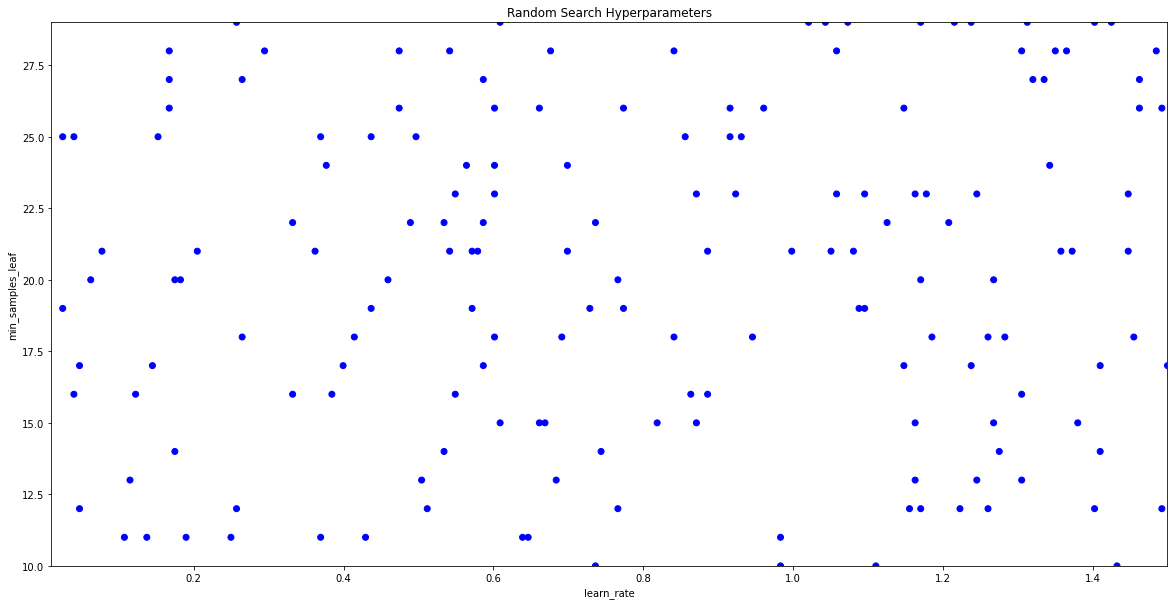

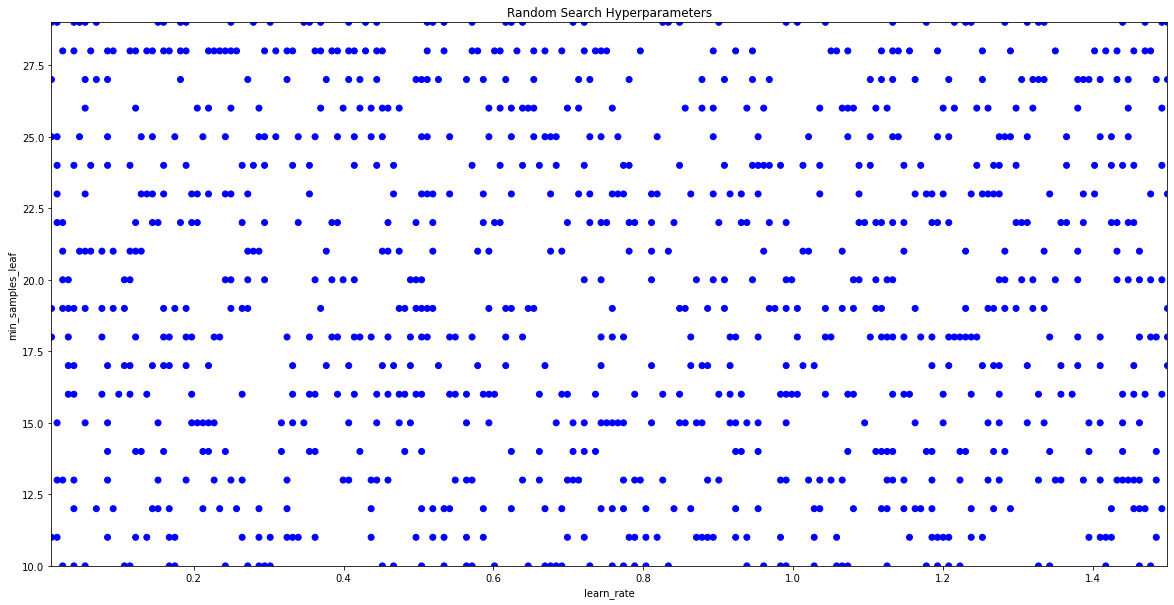

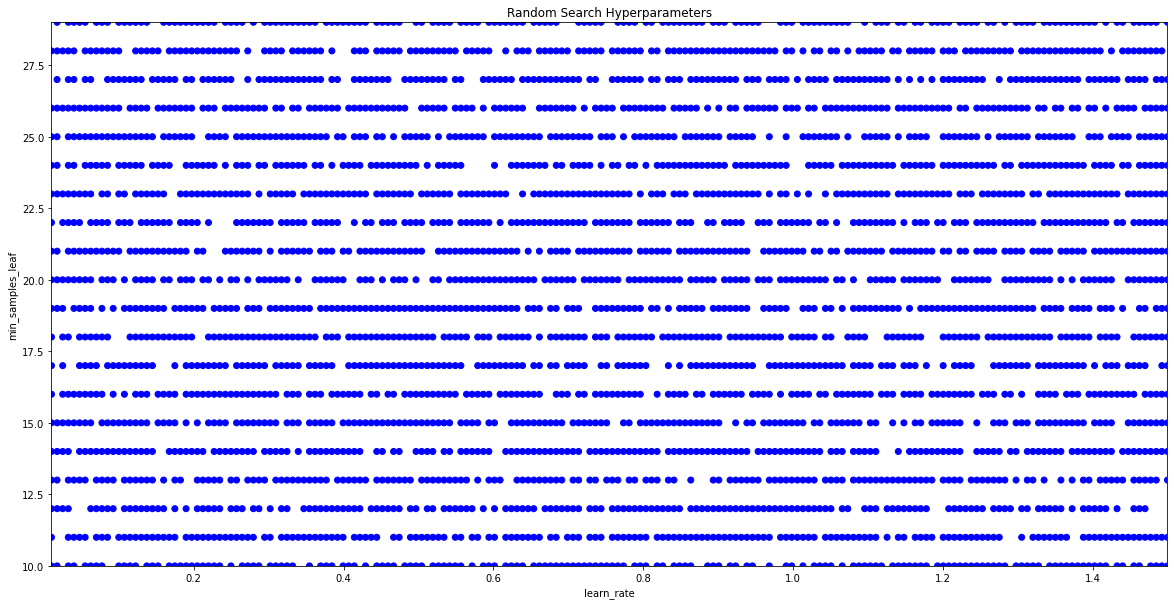

In [171]:
# Sample and visualise combinations
for x in [250, 1500, 5000]:
    sample_hyperparameters(x)
    visualize_search()

Notice how the bigger our sample space of a random search the more it looks like a grid search? In a later example we will look closer at comparing these two methods side by side.

## Random Search in Scikit Learn

In this chapter we will be introduced to Scikit Learn's `RandomizedSearchCV` module.  Just like with `GridSearchCV`, it is a more efficient way of undertaking random search than doing it manually, and allows us to easily capture extra information on our training. 

Since we have already covered GridSearchCV, we don't need to learn a lot of new steps. Let's recall the steps for a Grid Search:

1. Decide an algorithm to tune the hyperparameters for. (Sometimes called an estimator).
2. Define which hyperparameters we will tune.
3. Define a range of values for each hyperparameter.
4. Set a cross-validation scheme.
5. Define a scoring function so we can decide which grid square (model) was the best.
6. Decide to include extra useful information or functions.

There is only one difference when undertaking a random search:

7. We need to decide how many hyperparameter combinations we will randomly sample to build models and then undertake this sampling before we model. 

And that's pretty much it!

**Comparing Scikit Learn Modules**

It is therefore not a surprise to see how similar the functions are between the two Scikit Learn modules. See them here side by side:

![Grid vs Random](https://github.com/ML-Challenge/week5-preprocessing-and-tunning/blob/master/assets/2-18.png?raw=1)

It may not be obvious what is different since there is far more the same than not! There is really only two key differences:

* `n_iter`, which is the number of samples for the random search to take from our grid. In the previous example we did 300.
* `param_distributions`, is slightly different from `aram_grid`. We can optionally give information on how to sample such as using a particular distribution we provide. If we just give a list as we have been doing, the default is to sample `'uniformly'` meaning every item in the list (combination) has equal chance of being chosen.

**Build a RandommizedCV Object**

Now let's create a RandomSearchCV object, including the key changes we need to make. Creating a list of values and setting up the grid looks all very similar. 

```
# Set up the sample space
learn_rate_list = np.linspace(0.001, 2, 150)
min_samples_leaf_list = list(range(1, 51))

# Create the grid
parameter_grid = {
    'learning_rate': learning_rate_list,
    'min_samples_leaf': min_samples_leaf_list}
```

We firstly create the lists of hyperparameter values using the `np.linspace()` and `range()` functions, then set up the dictionary grid of hyperparameter values. 


```
# Define how many samples
number_models = 10
```

The crucial small difference is at the end, defining how many samples to take. Now we create the random search object

```
# Create a random search object
random_GBM_class = RandomizedSearchCV(
    estimator = GradientBoostingClassifier(),
    param_distributions = paramter_grid,
    n_iter = number_models,
    scoring = 'accuracy',
    n_jobs = 4,
    cv = 10,
    refit = True,
    return_train_score = True)
    
# Fit the object to our data
random+GBM_class.fit(X_train, y_train)
```

Note the slightly different name for the parameter grid, which is now called `'param_distributions'` as well as our new `n_iter` input for how many combinations to select and train models with. 

The attributes that form the output of RandomizedSearchCV are *exactly* the same as the GridSearchCV module However it would be interesting to see what numbers it sampled. We can visualize using the code from the previous chapter but where do we get details on the hyperparameters used?

It is found in the `cv_results_` dictionary that was returned and in the relevant `param_` columns. 

Let's extract the `learning_rate` and `min_samples_leaf` used, to plot them:

```
rand_x = list(random_GBM_class.cv_results['param_learning_rate'])
rand_y = list(random_GBM_class.cv_results['param_min_samples_leaf'])
```

Now we can plot our results. 

We set the x and y limits using NumPy's min and max functions over our list of hyperparameter values so that we can best see the coverage. 

```
# Make sure we set the limits of Y and X appropriately
x_lims = [np.min(learn_rate_list], np.max(learn_rate_list)]
y_lims = [np.min(mins_samples_leaf_list], np.max(mins_samples_leaf_list)]
```

Then we plot these combinations as a scatter plot.

```
# Plot grid results
plt.scatter(rand_y, rand_x, c=['blue']*10)
plt.gca().set(xlabel='learn rate', ylabel='min_samples_leaf', title='Random Search Hyperparameters')
plt.gca().set_xlim(x_lims)
plt.gca().set_ylim(y_lims)
plt.show()
```

For computational efficiency we only ran 10 models this time. Else it would take a while! 


![Random plot](https://github.com/ML-Challenge/week5-preprocessing-and-tunning/blob/master/assets/2-7.png?raw=1)


We will notice this is plot looks very similar to what plotted before as hyperparameter combinations without actually undertaking the model creation. Now we actually ran one, it looks very similar. Random search has a wide coverage of area for possible hyperparameters but it is a very pachy coverage.

### The RandomizedSeachCV Class

Just like the `GridSearchCV` library from Scikit Learn, `RandomizedSearchCV` provides many useful features to assist with efficiently undertaking a random search. We're going to create a `RandomizedSearchCV` object, making the small adjustment needed from the `GridSearchCV` object.

The desired options are:

* A default Gradient Boosting Classifier Estimator
* 5-fold cross validation
* Use accuracy to score the models
* Use 4 cores for processing in parallel
* Ensure we refit the best model and return training scores
* Randomly sample 10 models

The hyperparameter grid should be for `learning_rate` (150 values between 0.1 and 2) and `min_samples_leaf` (all values between 20 and 65).

In [172]:
# Create the parameter grid
param_grid = {'learning_rate': np.linspace(0.1, 2, 150), 'min_samples_leaf': list(range(20, 65))} 

In [173]:
from sklearn.model_selection import RandomizedSearchCV

# Create a random search object
random_GBM_class = RandomizedSearchCV(
    estimator = GradientBoostingClassifier(random_state=42),
    param_distributions = param_grid,
    n_iter = 10,
    scoring='accuracy', n_jobs=4, cv = 5, refit=True, return_train_score = True)

In [174]:
# Fit to the training data
random_GBM_class.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [175]:
# Print the values used for both hyperparameters
print(random_GBM_class.cv_results_['param_learning_rate'])
print(random_GBM_class.cv_results_['param_min_samples_leaf'])

[0.8523489932885906 1.923489932885906 1.6174496644295302
 0.9926174496644294 0.5335570469798657 0.32953020134228184
 0.8140939597315436 1.5409395973154363 1.2476510067114095
 1.1456375838926176]
[42 45 48 39 31 49 41 25 48 50]


### RandomSearchCV in Scikit Learn

Let's practice building a RandomizedSearchCV object using Scikit Learn.

The desired options are:

* A RandomForestClassifier Estimator with default 80 estimators
* 3-fold cross validation
* Use AUC to score the models
* Use 4 cores for processing in parallel
* Ensure we refit the best model and return training scores
* Randomly sample 5 models for processing efficiency

The hyperparameter grid should be for `max_depth` (all values between and including 5 and 25) and `max_features` ('auto' and 'sqrt').

In [176]:
# Create the parameter grid
param_grid = {'max_depth': list(range(5,26)), 'max_features': ['auto' , 'sqrt']} 

In [177]:
# Create a random search object
random_rf_class = RandomizedSearchCV(
    estimator = RandomForestClassifier(n_estimators=80, random_state=42),
    param_distributions = param_grid, n_iter = 5,
    scoring='roc_auc', n_jobs=4, cv = 3, refit=True, return_train_score = True)

In [178]:
# Fit to the training data
random_rf_class.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [179]:
# Print the values used for both hyperparameters
print(random_rf_class.cv_results_['param_max_depth'])
print(random_rf_class.cv_results_['param_max_features'])

[23 24 24 22 19]
['sqrt' 'sqrt' 'auto' 'auto' 'auto']


## Comparing Grid and Random Search

In the previous chapters we looked at both Grid and Random search in depth. So, it is a good idea to stop and reinforce our knowledge on these two valuable techniques.

There are a number of similarities for these techniques:

* Both are automated ways of tuning different hyperparameters.
* For both we set the grid to sample from (which hyperparameters and values for each).
* For both we need to think carefully about which hyperparameters and values to sample from as our model will only be as good as the grid we set!
* And for both we set a cross-validation scheme and scoring function.

There are also some key differences between these two techniques:

| Grid Search | Random Search |
| ----------- | ------------- |
| Exhaustively tries all the combinations within<br> the sample space | Randomly selects a subset combinations<br> within the sample space (that we must specify) |
| No sampling methodology | Can select a sampling methodology (other<br> than `uniform` which is default |
| More computationally expensive | Less computationally expensive |
| Guaranteed to find the best score in the sample space | Not guaranteed to find the best score in<br> the sample space (but likely to find a *good* one *faster* |

**So which technique should we use?**

As we often say in data science - 'It depends'. However there are some things we can consider. 

* Firstly, the more data we have, the stronger the argument for random search.
* More hyperparameters and values to try also means random search might be a better option. 
* Additionally if we don't have a lot of time or computing power, random search will be more economical. Remember, random search has more chance of getting a good result faster, even if not the absolute best.

Let's do some examples to illustrate the differences between grid and random search visually and conceptually.

### Grid and Random Search Side by Side

Visualizing the search space of random and grid search together allows us to easily see the coverage that each technique has and therefore brings to life their specific advantages and disadvantages.

In this example, we will sample hyperparameter combinations in a grid search way as well as a random search way, then plot these to see the difference.

In [180]:
# Sample grid coordinates
grid_combinations_chosen = combinations_list[0:300]

In [181]:
# Print result
grid_combinations_chosen

[[0.01, 10],
 [0.01, 11],
 [0.01, 12],
 [0.01, 13],
 [0.01, 14],
 [0.01, 15],
 [0.01, 16],
 [0.01, 17],
 [0.01, 18],
 [0.01, 19],
 [0.01, 20],
 [0.01, 21],
 [0.01, 22],
 [0.01, 23],
 [0.01, 24],
 [0.01, 25],
 [0.01, 26],
 [0.01, 27],
 [0.01, 28],
 [0.01, 29],
 [0.01, 30],
 [0.01, 31],
 [0.01, 32],
 [0.01, 33],
 [0.01, 34],
 [0.01, 35],
 [0.01, 36],
 [0.01, 37],
 [0.01, 38],
 [0.01, 39],
 [0.01, 40],
 [0.017487437185929648, 10],
 [0.017487437185929648, 11],
 [0.017487437185929648, 12],
 [0.017487437185929648, 13],
 [0.017487437185929648, 14],
 [0.017487437185929648, 15],
 [0.017487437185929648, 16],
 [0.017487437185929648, 17],
 [0.017487437185929648, 18],
 [0.017487437185929648, 19],
 [0.017487437185929648, 20],
 [0.017487437185929648, 21],
 [0.017487437185929648, 22],
 [0.017487437185929648, 23],
 [0.017487437185929648, 24],
 [0.017487437185929648, 25],
 [0.017487437185929648, 26],
 [0.017487437185929648, 27],
 [0.017487437185929648, 28],
 [0.017487437185929648, 29],
 [0.0174874371859

In [182]:
# Create a list of sample indexes
sample_indexes = list(range(0,len(combinations_list)))

In [183]:
# Randomly sample 300 indexes
random_indexes = np.random.choice(sample_indexes, 300, replace=False)

In [184]:
# Use indexes to create random sample
random_combinations_chosen = [combinations_list[index] for index in random_indexes]

In [185]:
def visualize_search(grid_combinations_chosen, random_combinations_chosen):
    grid_y, grid_x = [x[0] for x in grid_combinations_chosen], [x[1] for x in grid_combinations_chosen]
    rand_y, rand_x = [x[0] for x in random_combinations_chosen], [x[1] for x in random_combinations_chosen]

    # Plot all together
    plt.scatter(grid_y + rand_y, grid_x + rand_x, c=['red']*300 + ['blue']*300)
    plt.gca().set(xlabel='learn_rate', ylabel='min_samples_leaf', title='Grid and Random Search Hyperparameters')
    plt.gca().set_xlim([0.01, 3.0])
    plt.gca().set_ylim([5, 24])
    plt.show()

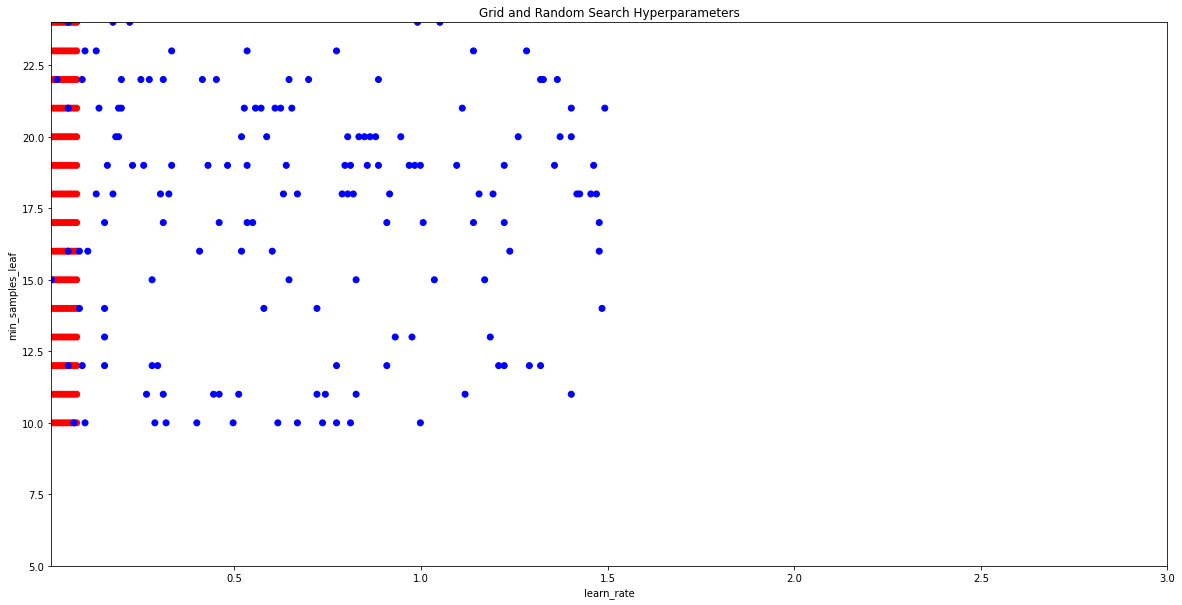

In [186]:
# Call the function to produce the visualization
visualize_search(grid_combinations_chosen, random_combinations_chosen)

We can really see how a grid search will cover a small area completely whilst random search will cover a much larger area but not completely.